In [2]:
import math

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [4]:
def grover_oracle(marked_states):
    """
    Building grover oracle for multiple marked states, assuming all input marked state have the same number of bits
    Parameters: 
        marked_states (str or list): marked states of oracle
    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

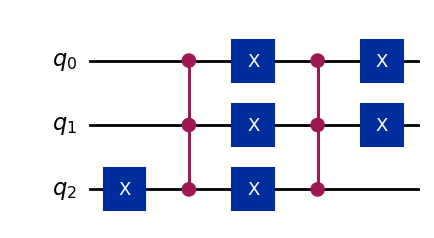

In [5]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

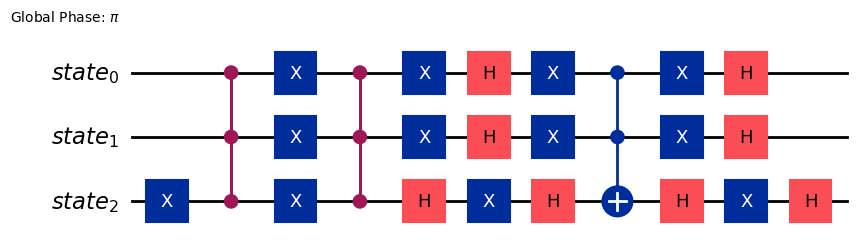

In [6]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [7]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

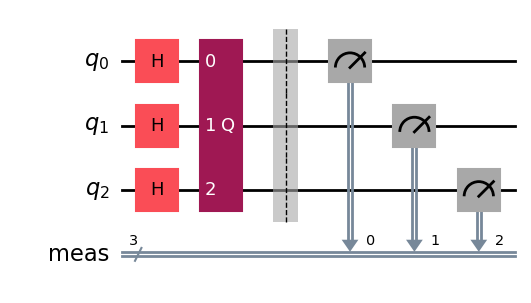

In [8]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

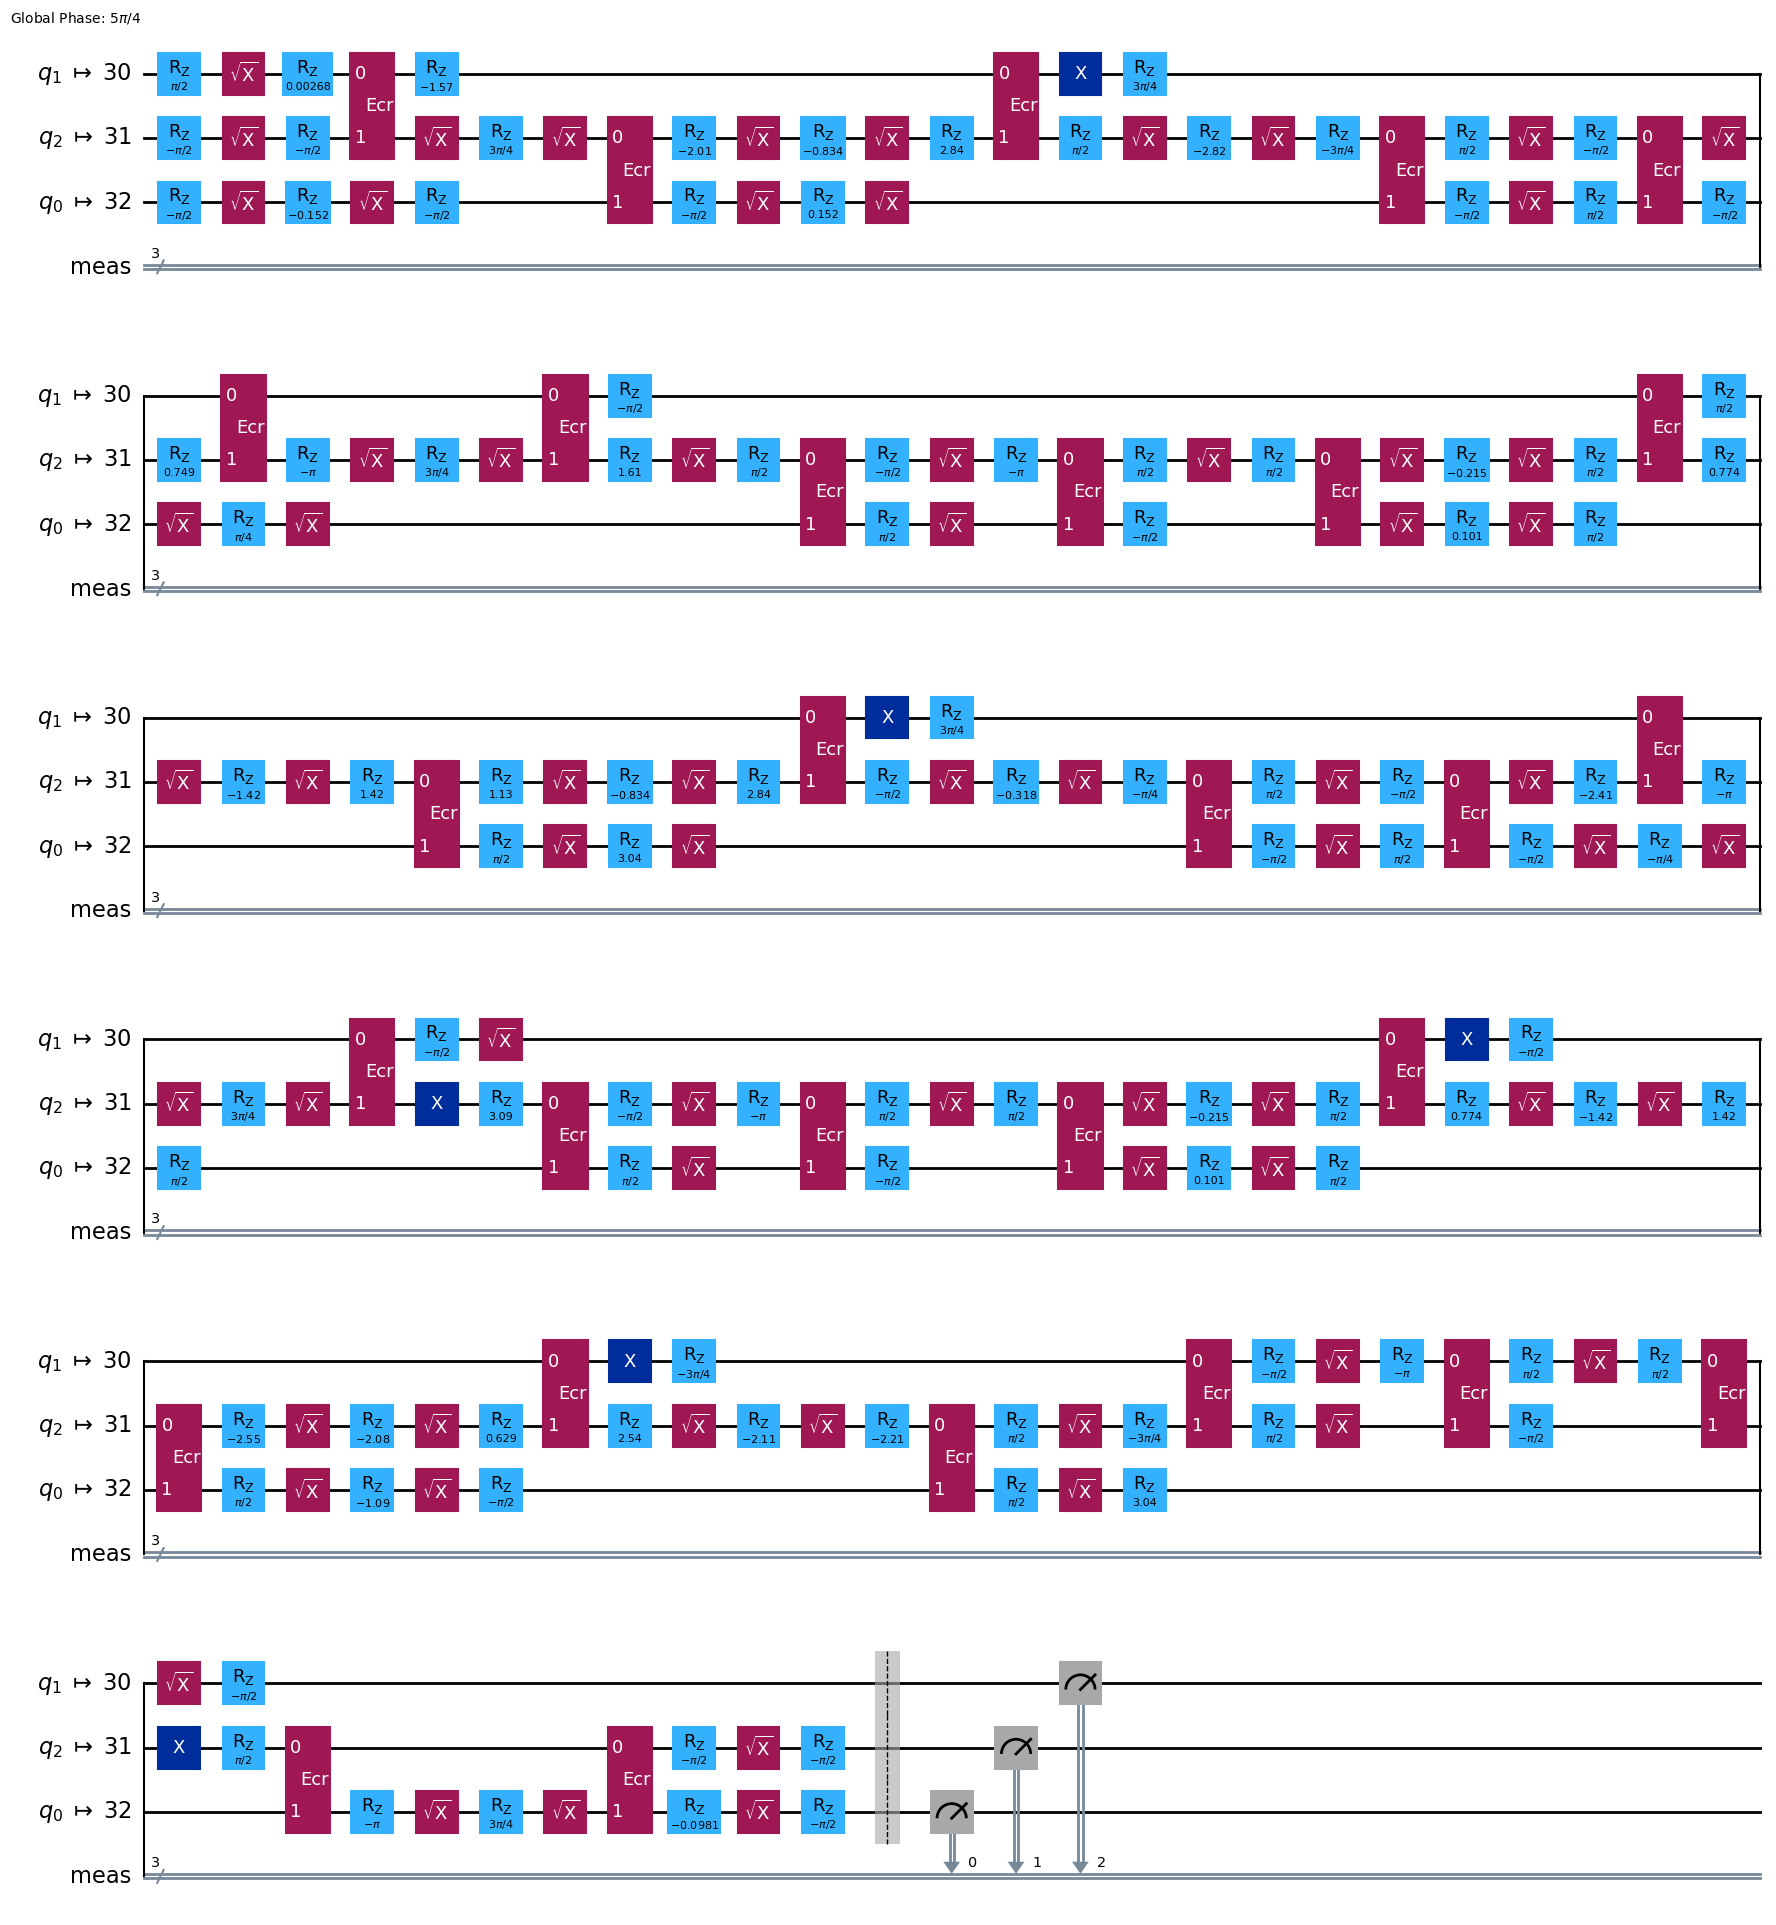

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [10]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

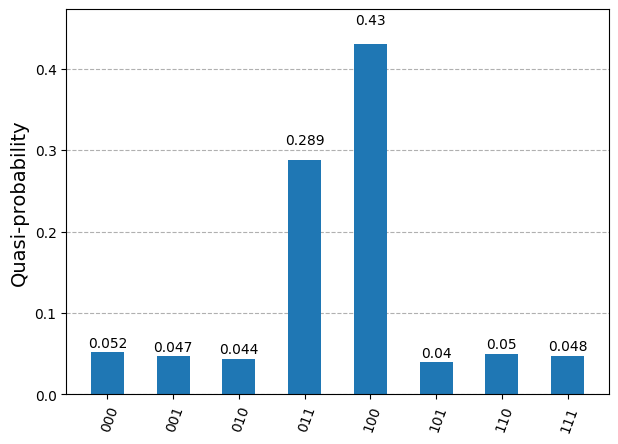

In [11]:
plot_distribution(dist)

In [12]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.34.0'

In [13]:
import qiskit
qiskit.version.get_version_info()

'1.2.1'